# Lensing Background Galaxies by Foreground Halos

#### Spencer Everett, SLAC 7/29/2015

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
import cPickle as pickle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
%matplotlib inline

In [4]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

Import the convergence and shear maps:

In [5]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa',FITS=False)

In [6]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

Import the foreground galaxy catalog for the (0,0,0,0) field:

In [7]:
config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)

Generate a background galaxy catalog in a small part of the same field with 10 sources per square arcminute:

In [8]:
#d = [1.85,1.15,-1.85,-1.15] #40x40 arcmin
d = [1.65,1.35,-1.65,-1.35]
#d=[1.55,1.52,-1.61,-1.59]
B = pangloss.BackgroundCatalog(N=20.0,sigma_e=0.01,domain=d,field=[0,0,0,0])
B.lens_by_map(K,S)
B.galaxy_count

6479

In [9]:
B.drill_lightcones(foreground=F,save=False)

0   0.0 %
648   10.0 %
1296   20.0 %
1944   30.0 %
2592   40.0 %
3240   50.0 %
3888   60.0 %
4536   70.0 %
5184   80.0 %
5832   90.0 %


In [9]:
galaxy_counts = [B.lightcones[i].galaxy_count for i in range(len(B.lightcones))]
mean_galaxies = np.mean(galaxy_counts)
std_galaxies = np.std(galaxy_counts)
print mean_galaxies,'+/-',std_galaxies

954.215002315 +/- 66.305014261


In [10]:
B.lens_by_halos()

0   0.0 %
648   10.0 %
1296   20.0 %
1944   30.0 %
2592   40.0 %
3240   50.0 %
3888   60.0 %
4536   70.0 %
5184   80.0 %
5832   90.0 %
average CPU time per background galaxy:  0.0281197342502 +/- 0.0107733854723


In [1]:
K.plot(fig_size=12,subplot=[1.55,1.52,-1.61,-1.59])
S.plot()
B.plot(lensed='all',graph='stick')

NameError: name 'K' is not defined

In [13]:
gg_int = B.calculate_corr(corr_type='gg',lensed='none',max_sep=5)
gg_map = B.calculate_corr(corr_type='gg',lensed='map',max_sep=5)
gg_halo = B.calculate_corr(corr_type='gg',lensed='halo',max_sep=5)

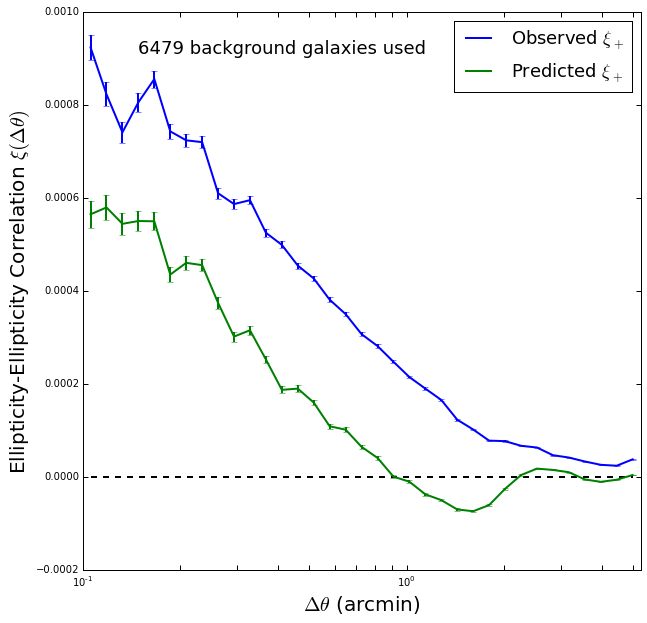

In [14]:
pangloss.plotting.plot_corr(gg_int,corr_type='gg',corr_comp='plus',lensed='none',color='black',galaxy_count=B.galaxy_count)
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='plus',lensed='map',color='green')
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='plus',lensed='halo',color='purple')

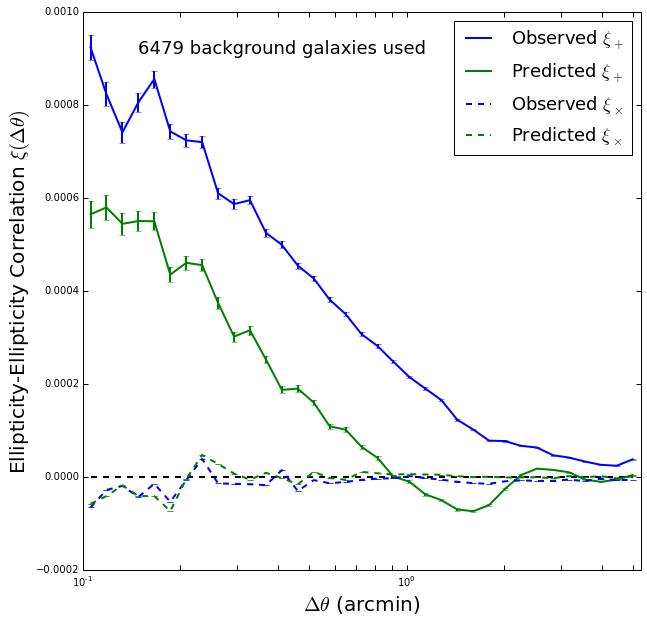

In [15]:
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='plus',lensed='map',color='green',galaxy_count=B.galaxy_count)
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='plus',lensed='halo',color='purple')
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='cross',lensed='map',color='green')
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='cross',lensed='halo',color='purple')